# Modelado de la función sinusoidal con NeuralODEs

Las neural ODE son la forma de poner los dos mundos de ML y ODE juntos. La forma mas fácil de explicarlo es que en vez de aprender la transformación no lineal directamente, queremos aprender su estructura. Así en vez de hacer $y = ML(x)$, ponemos en el modelo de machine learning la derivada $y^{\prime}(x) = ML(x)$, y resolvemos la ODE. Uno de los motivos es que haciendo esto y resolviendo por el metodo mas simple que es el de Euler, lo que obtenemos es lo equivalente a una red neuronal residual que es un tipo de red neuronal.
El método de Euler es
\begin{equation}
    \Delta y = (y_{next} - y_{prev}) = \Delta x ML(x)
\end{equation}
lo cual implica
\begin{equation}
    y_{i+1} = y_{i} + \Delta x ML(x)
\end{equation}
El cual es similar a una ResNet.

Para resolver ecuaciones diferenciales usamos la libreria DifferentialEquations. Un aspecto importante es que podemos poner todos los elementos necesarios en función del vector de parámetros, como por ejemplo, u0, el tiempo de simulación.

Si recordamos una capa es justamente una función diferenciable que toma un vector de tamaño n y saca un vector de tamaño m. Tradicionalmente fueron funciones simples como multiplicaciones de matrices, pero se experimentó con funciones mucho mas complejas.

Resulta que los métodos de resolución de ecuaciones diferenciales entran en este framework también, los mismos toman un vector p y tienen como output otro vector que es la solución. Mas aún esta es diferenciable. 

En cualquier caso, una capa de Neural ODE lo que hace es tratar a la red neuronal como la función diferenciada, es decir la $y^{\prime}$ y tratar de resolver ese problema.

Este nuevo tipo de redes parametrizan la derivada de un estado oculto usando una red neuronal. La salida de esa red neuronal se calcula mediante un método de resolución de ecuaciones diferenciales.

Si nos fijamos en las ResNet si representamos el estado de la $t$ capa oculta mediante $h_t$, lo que se busca es obtener lo que sería la diferencia $\Delta h_{t+1}$ usando los pesos de la capa $h_t$ y así al sumar $h_t$ con $\Delta h_{t+1}$ obtener el estado $h_{t+1}$ de la capa $t+1$. Haciendo esto se vio que se reducía el número de parámetros y esto permitía obtener redes mas y mas profundas las cuales permitían tener un menor error al final. En este ejemplo tomamos como si fuéramos de una capa $t$ a una capa $t+1$ pero lo normal es que los bloques residuales tengan mas capas internas. Esto mantiene información de la señal inicial y en vez de aprender los pesos para llevar $x \to y$ aprende la diferencia $x - y \to \Delta x$ la cual es mas fácil para capas profundas que son las que menos cambian. 

Ahora si suponemos como en el ejemplo tendríamos
\begin{equation}
    h_{t+1} = h_t + f(h_t,\theta_t)
\end{equation}
donde $t\in\{ 0,...,T \}$ y $h_t \in \mathbb{R}^D$ y siendo $\theta_t$ los parámetros (que serían los pesos). Si estos pasos se hacen cada vez mas pequeños en el caso continuo esto pasa a ser por semejanza con el método de Euler
\begin{equation}
    \frac{d h(t)}{dt} = f(h(t),t,\theta)
\end{equation}
donde ahora la dinámica de cada estado oculto $h_t$ queda parametrizada por una ecuación diferencial ordinaria. Así empezando por $h(0)$ se puede definir la salida $h(T)$ para ser la solución de la ecuación diferencial en un tiempo $T$ y esto se puede calcular mediante una caja negra que resuelve ecuaciones diferenciales y obtiene la solución posible con la precisión deseada.

Ahora, nosotros tenemos parámetros $\theta$ y necesitamos una forma de entrenar nuestra red para actualizar tales parámetros. Para esto no podemos usar backpropagation directamente por lo que para obtener los gradientes de la función costo con respecto a los parámetros que necesitamos se utiliza una función adjunta $a(t)$ y se resuelve otra ecuación diferencial.

Veamos esto mas en detalle nosotros tenemos hasta ahora que una función loss $L$ la resolvemos como
\begin{equation}
    L(z(t_1)) = L\left(z(t_0) + \int_{t_0}^{t_1} f(z(t),t,\theta) dt \right) = L(ODESolve(z(t_0),f,t_0,t_1,\theta))
\end{equation}

Ahora sí, podemos entrenar la red neuronal. Una de las ventajas es que estos flujos de redes neuronales son continuos por lo tanto se puede extrapolar en datos para así tener una predicción

Lo primero que tenemos que hacer es ver como depende el gradiente de $L$ de cada estado oculta $z(t)$ en cada instante. A esta cantidad es a la que se la llama adjunta $a(t) = \frac{\partial L}{\partial z(t)}$ y su dinámica está dada por

\begin{equation}
    \frac{d a(t)}{d t} = - a(t)^T \frac{\partial f(z(t),t,\theta)}{\partial z}.
\end{equation}

Lo que hacemos es calcular $\frac{\partial L}{\partial z(t_0)}$ resolviendo la ecuación diferencial de $a(t)$ en reversa, es decir el valor inicial es $\frac{\partial L}{\partial z(t_1)}$. Así podemos calcular
\begin{equation}
    \frac{d L}{d \theta} = - \int_{t_1}^{t_0} a(t)^T\frac{\partial f(z(t),t,\theta)}{\partial \theta}dt
\end{equation}

In [1]:
using Flux
using DifferentialEquations
using DiffEqFlux
using Plots
using Flux: train!
using Distributions
using Flux.Data: DataLoader, Flux

Para esto tenémos que crear una ecuación diferencial parametrizada que me permita aprender la solución que buscamos. En este caso le damos a la NeuralODE una dinámica que es una combinación de funciones periódicas, con esto la NeuralODE debería ser capaz de entrenar los parámetros para poder llegar al resultado correcto.

In [36]:
tbegin = 0f0
tend = 1f0
datasize = 400
t = range(tbegin, tend, length=datasize)
tspan = (tbegin, tend)
u0 = Float32[0.0]

1-element Vector{Float32}:
 0.0

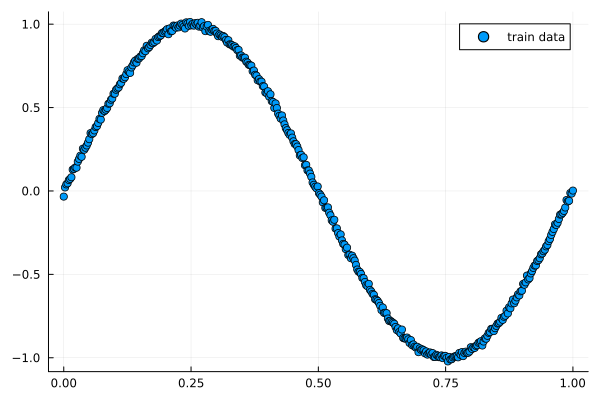

In [37]:
train_t = Float32.(t)
train_u = Float32.(sin.(2π*t) .+ rand(Normal(0, 0.01), datasize))

Plots.scatter(train_t, train_u, label="train data")

In [38]:
dudt = Chain(Dense(1 => 25, tanh),
Dense(25 => 15, tanh),
Dense(15 => 15, tanh),
Dense(15 => 10, tanh),
Dense(10 => 1))

n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=t, reltol=1e-3, abstol=1e-3)
ps = Flux.params(n_ode)

Params([Float32[0.39474234, 0.29034707, 0.22136995, -0.35722184, 0.28224933, 0.21822637, -0.025580395, -0.1694352, 0.14054969, 0.32521904  …  -0.23399642, -0.5434068, -0.7012748, 0.22805756, 0.36259896, 0.7153138, -0.6675901, -0.40871283, -0.29188785, 0.0]])

In [31]:
function loss_n_ode()
    prediccion = n_ode(u0)
    #loss = Flux.crossentropy(prediccion[1,:], train_u)
    loss = sum(abs2, prediccion[1,:] .- train_u)
    return loss
end

iter = 0

cb = function ()
    global iter
    iter += 1
    if(iter % 50 == 0)
        actual_loss = loss_n_ode()
        println("Actual loss is: ", actual_loss)
    end
end

n_epochs = 400
opt = ADAM(0.1)
data = Iterators.repeated((),n_epochs)
Flux.train!(loss_n_ode, ps, data, opt, cb = cb)

Actual loss is: 99.444405
Actual loss is: 99.44079
Actual loss is: 99.44131
Actual loss is: 99.441315
Actual loss is: 99.441666
Actual loss is: 99.44141
Actual loss is: 99.442375
Actual loss is: 99.44237


Creamos el problema de ecuaciones diferenciales parametrizado. Además creamos lo que sería nuestra red neuronal que consiste en el resolvedor de ODEs.

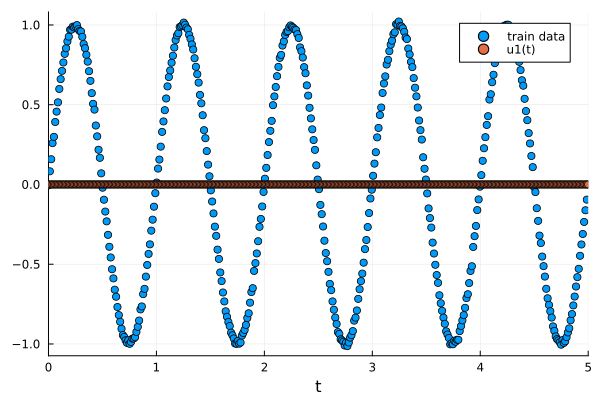

In [35]:
Plots.scatter(train_t, train_u, label="train data")
Plots.scatter!(n_ode(u0))

La razón principal del bajo rendimiento de la ODE neuronal se debe a la naturaleza de la función seno, que mapea números reales del conjunto de números reales (R) al intervalo [-1, 1]. Esta característica de la función seno presenta un desafío porque no es factible que ningún campo vectorial replique con precisión este comportamiento. 
Nguyen, Long Huu and Malinsky, Andy, "Exploration and Implementation of Neural Ordinary Differential Equations" (2020). Capstone Showcase. 8.
https://scholarworks.arcadia.edu/showcase/2020/comp_sci_math/8